# EECS 491: Probabilistic Graphical Models Assignment 4
**David Fan**

4/11/18

# Exercise 1

In this notebook we will implement the EM algorithm to tune the means of a 2D Gaussian Mixture Model with fixed covariance matrices.

First let's load up our data and import the python packages we will be using:

In [2]:
import csv, copy, gzip, pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2

%matplotlib inline

In [3]:
with open('data/faithful.txt', 'rt') as csvfile:
    dataReader = csv.reader(csvfile, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

Now let's initialize our Gaussian Mixture Model. First let's set how many Gaussian distributions we will have in our mixture:

In [4]:
ngmm = 2 # quantity of Gaussian Mixture Model

Now let's initialize the mean and covariance for each Gaussian distribution. The covariance matrix must be positive-definite.

In [5]:
mu = np.asarray([[4, 80], 
                 [8, 80]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]]]
                  ).astype('float')

The following function checks covariance matrices for validity if we decide to change up the covariance matrix.

In [6]:
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))

Convariance Matrices are Legal? : True


With all of our Gaussian distributions set up, let's create a dictionary that will store all of our Gaussians.

In [9]:
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

The following function will plot our Gaussian Mixture Model. It is taken from the demo.

In [10]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

Let's test it:

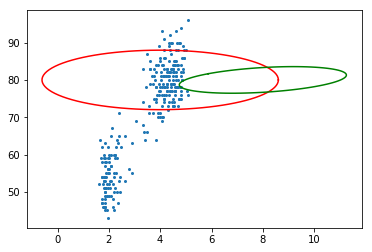

In [11]:
gmmplot(data, gmm)

Now let's optimize our GMM. As stated above we will be using the Expectation-Maximization algorithm to tune our mean. 

In our Expectation step we will compute:

$$
p_{n,k}=p(c_k \; | \; x^{(n)}, \theta_{1:K})=\frac{p(x^{(n)} \; | \; c_k,\theta_k) p(c_k)}{\sum_k p(x^{(n)} \; | \; c_k, \theta_k) p(c_k)}
$$

where

$$
p(x^{(n)} \; | \; c_k,\theta_k) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}exp\{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\Sigma^{-1}(\mathbf{x}-\mathbf{\mu})\}
$$

and the prior is given in the parameters.

In our Maximization step we will compute the mean for the next cycle using:

$$
p_k = \frac{\sum_n p_{n,k}}{n}
$$

$$
\mu_k \leftarrow \frac{\sum_n p_{n,k}x^{(n)}}{np_k}
$$

In [12]:
def expectation(data, gmmcp):
    rows,dims = data.shape
    cols = len(gmmcp)
    posterior = np.zeros((rows,cols))
    for row in range(rows):
        for col in range(cols):
            gmm = gmmcp[col]
            mean = gmm['mean']
            covariance = gmm['covariance']
            prior = gmm['prior']
            num = multivariate_gaussian(dims, mean, covariance, data[row]) * prior
            denom = 0
            for j in range(cols):
                gmm = gmmcp[j]
                mean = gmm['mean']
                covariance = gmm['covariance']
                prior = gmm['prior']
                g = multivariate_gaussian(dims, mean, covariance, data[row])
                denom += g * prior
            posterior[row, col] = num/denom
    return posterior

In [16]:
def multivariate_gaussian(dims, mean, covariance, example):
    A = 1/((2*np.pi)**(dims/2)*np.linalg.det(covariance)**.5)
    B = np.exp(-.5*(example - mean).T.dot(np.linalg.inv(covariance).dot((example - mean))))
    return A * B

In [17]:
def maximization_mean(posterior, data, gmmcp):
    update_gmm = gmmcp
    pk = np.zeros(2)
    rows, cols = posterior.shape
    for col in range(cols):
        for row in range(rows):
            pk[col] += posterior[row, col]
    for col in range(cols):
        gmm = update_gmm[col]
        mean = 0
        for row in range(rows):
            mean += posterior[row,col]*(data[row])/pk[col]
        gmm['mean'] = mean
    return gmmcp

Now let's run our algorithm:

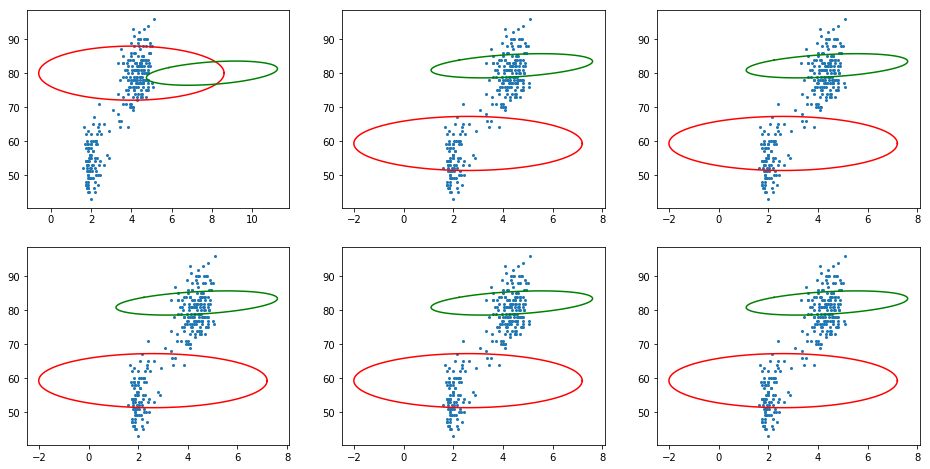

In [18]:
# make a true copy of our model
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(10):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization_mean(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)